In [21]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from itertools import product, combinations
import math
from utils import save_rectangle_room, save_feature, create_model
import os
import torch
from torch.autograd import Variable

In [16]:
bestmodels = {
    "CNN_Class": "/playpen/zytang/best_models/results_CNN_Class_lr1e-06_bs32_drop0/best_valid.pth",
    "CNN_Reg": "/playpen/zytang/best_models/results_CNN_Reg_lr0.0001_bs64_drop0/best_valid.pth",
    "CRNN_Class": "/playpen/zytang/best_models/results_CRNN_Class_lr0.0001_bs64_drop0/best_valid.pth",
    "CRNN_Reg": "/playpen/zytang/best_models/results_CRNN_Reg_lr0.000600298822924003_bs64_drop0/best_valid.pth"
}
CNN_Class = create_model("Class", "CNN")
CNN_Class.load_state_dict(torch.load(bestmodels['CNN_Class']))
CNN_Reg = create_model("Reg", "CNN")
CNN_Reg.load_state_dict(torch.load(bestmodels['CNN_Reg']))
CRNN_Class = create_model("Class", "CRNN")
CRNN_Class.load_state_dict(torch.load(bestmodels['CRNN_Class']))
CRNN_Reg = create_model("Reg", "CRNN")
CRNN_Reg.load_state_dict(torch.load(bestmodels['CRNN_Reg']))

In [2]:
def getvec(Width, Length, Height):
    return [Width, Length, Height]

def getdir(Distance, Azimuth, Elevation):
    return [Distance, np.deg2rad(Azimuth), np.deg2rad(Elevation)]

In [3]:

dim_slider = interactive(getvec, Width=(2,10,0.1), Length=(2,10,0.1), Height=(2,10,0.1))
print('Please choose room dimensions:')
display(dim_slider)


Please choose room dimensions:


interactive(children=(FloatSlider(value=6.0, description='Width', max=10.0, min=2.0), FloatSlider(value=6.0, d…

In [4]:
dims = dim_slider.result
print('Chosen room dimensions: {}'.format(dims))

offset = 0.5
lis_slider = interactive(getvec, Width=(offset,dims[0]-offset,0.1), Length=(offset,dims[1]-offset,0.1), Height=(offset,dims[2]-offset,0.1))
print('Please choose listener location:')
display(lis_slider)

Chosen room dimensions: [6.0, 6.0, 6.0]
Please choose listener location:


interactive(children=(FloatSlider(value=3.0, description='Width', max=5.5, min=0.5), FloatSlider(value=3.0, de…

In [5]:
src_slider = interactive(getdir, Distance=(1,np.max(dims),0.1), Azimuth=(0,360,0.1), Elevation=(-90,90,0.1))
print('Please choose source direction:')
display(src_slider)

Please choose source direction:


interactive(children=(FloatSlider(value=3.5, description='Distance', max=6.0, min=1.0), FloatSlider(value=180.…

In [65]:
lis_loc = lis_slider.result
src_dir = src_slider.result
r = src_dir[0]
phi = src_dir[1]
theta = src_dir[2]
src_loc = [ lis_loc[0] + r * math.sin(theta) * math.cos(phi),
            lis_loc[1] + r * math.sin(theta) * math.sin(phi),
            lis_loc[2] + r * math.cos(theta)]
print('source location: {}, listener location: {}'.format(src_loc, lis_loc))

source location: [3.1439616372995203, 0.9916315952232018, 3.596432223878238], listener location: [3.0, 3.0, 3.0]


<IPython.core.display.Javascript object>


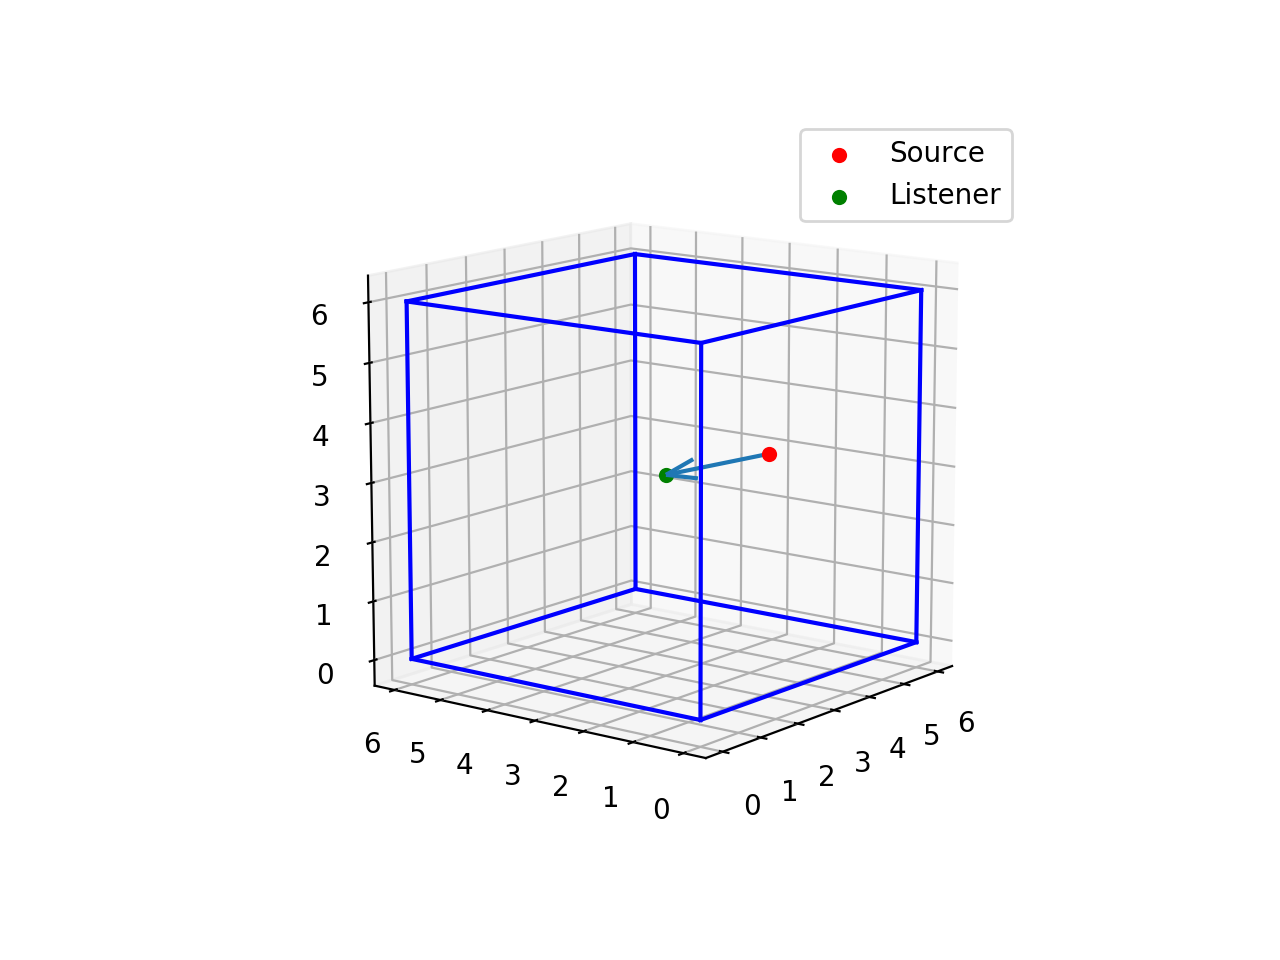

In [66]:

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect("equal")
for s, e in combinations(np.array(list(product([0, dims[0]], [0, dims[1]], [0, dims[2]]))), 2):
    if np.sum(np.abs(s-e)) in dims:
        ax.plot3D(*zip(s, e), color="b")
        
ax.quiver(src_loc[0],src_loc[1],src_loc[2],lis_loc[0]-src_loc[0],lis_loc[1]-src_loc[1],lis_loc[2]-src_loc[2],arrow_length_ratio=0.3)
ax.scatter(src_loc[0],src_loc[1],src_loc[2], c='r', label='Source')
ax.scatter(lis_loc[0],lis_loc[1],lis_loc[2], c='g', label='Listener')
ax.legend()
plt.show()

In [67]:
if not ((0 < lis_loc[0] < dims[0]) and (0 < lis_loc[1] < dims[1]) and (0 < lis_loc[2] < dims[2])):
    print('Listener out of bounds!')
elif not ((0 < src_loc[0] < dims[0]) and (0 < src_loc[1] < dims[1]) and (0 < src_loc[2] < dims[2])):
    print('Source out of bounds!')
else:
    working_dir = 'data'
    speech_path = 'data/1272-128104-0000.flac'
    if not os.path.exists(working_dir):
        os.makedirs(working_dir)
    obj_path = os.path.join(working_dir, 'room.obj')
    save_rectangle_room(dims, obj_path)
    feature_path = None
    while not feature_path:    
        feature_path = save_feature(obj_path, speech_path, src_loc, lis_loc)
    print(feature_path)

data/room_conv.npy


In [68]:
feature = torch.from_numpy(np.moveaxis(np.load(feature_path), -1, 0))
feature = Variable(feature.cuda())
feature = feature.float()
feature = feature.unsqueeze(0)
predict = CRNN_Reg(feature)
outputs = torch.sum(predict, 1)/25
print(outputs.data[0])
cnn_reg_predict = CNN_Reg(feature)
print(cnn_reg_predict.data[0])
outputs = np.array(outputs.data[0]) / np.linalg.norm(outputs.data[0])
cnn_reg_predict = np.array(cnn_reg_predict.data[0]) / np.linalg.norm(cnn_reg_predict.data[0])

tensor([ 0.0671, -0.9512,  0.0758], device='cuda:0')
tensor([ 0.0372, -0.4616, -0.0533], device='cuda:0')


<IPython.core.display.Javascript object>


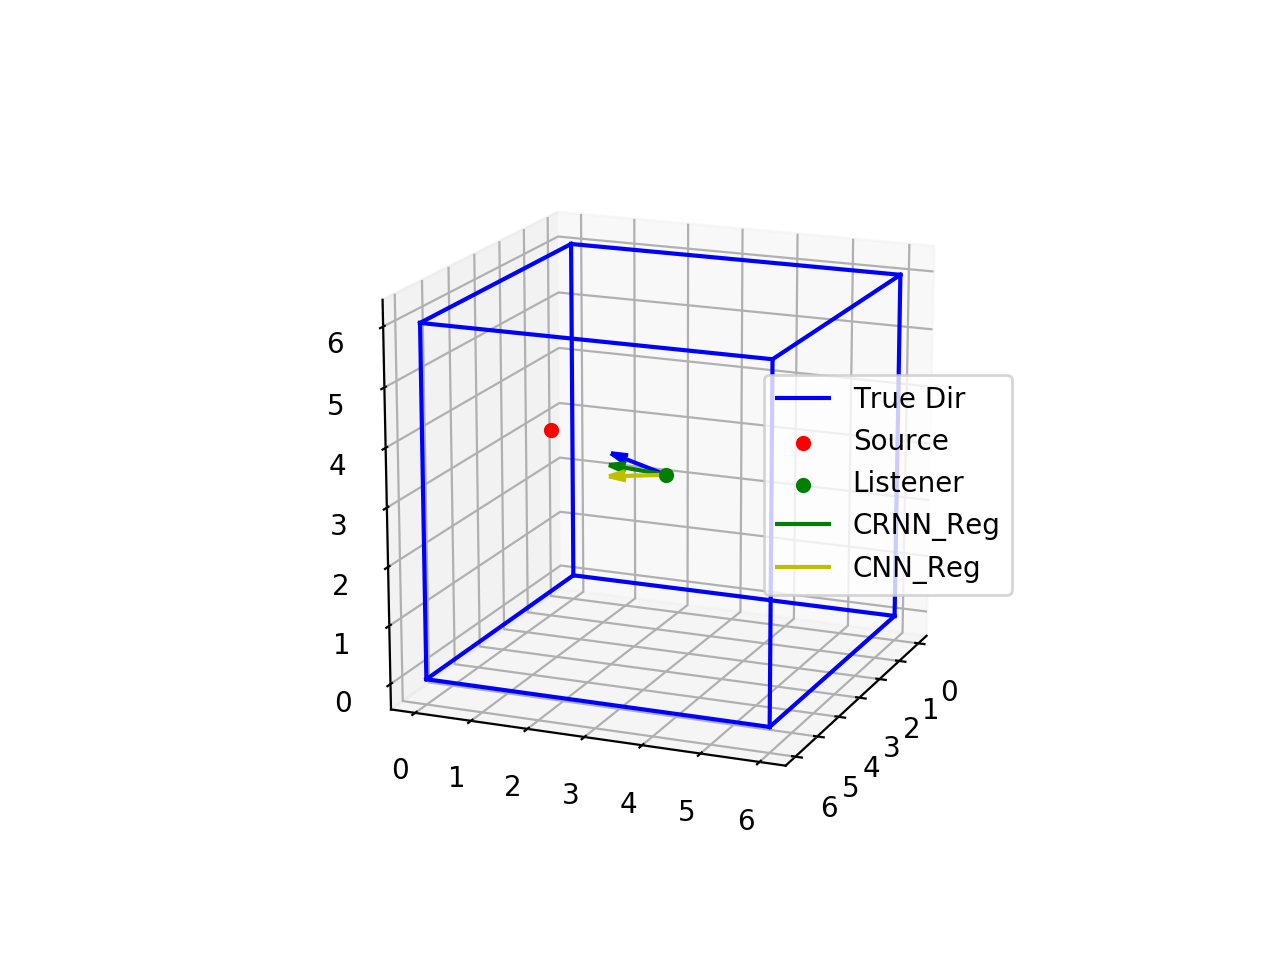

In [69]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect("equal")
for s, e in combinations(np.array(list(product([0, dims[0]], [0, dims[1]], [0, dims[2]]))), 2):
    if np.sum(np.abs(s-e)) in dims:
        ax.plot3D(*zip(s, e), color="b")
true_dir = np.array(src_loc) - np.array(lis_loc)
true_dir = true_dir / np.linalg.norm(true_dir)
ax.quiver(lis_loc[0],lis_loc[1],lis_loc[2],true_dir[0],true_dir[1],true_dir[2],arrow_length_ratio=0.3,label='True Dir', color='b')
ax.scatter(src_loc[0],src_loc[1],src_loc[2], c='r', label='Source')
ax.scatter(lis_loc[0],lis_loc[1],lis_loc[2], c='g', label='Listener')
ax.quiver(lis_loc[0],lis_loc[1],lis_loc[2],outputs.data[0],outputs.data[1],outputs.data[2],arrow_length_ratio=0.3,label='CRNN_Reg',color='g')
ax.quiver(lis_loc[0],lis_loc[1],lis_loc[2],cnn_reg_predict.data[0],cnn_reg_predict.data[1],cnn_reg_predict.data[2],arrow_length_ratio=0.3,label='CNN_Reg',color='y')
ax.legend()
plt.show()